<h1>Build feature and output arrays

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# collect data
for wpp in WPP_production_wind:
    all_turbine_types.append([wpp["Turbine"] if pd.notna(wpp["Turbine"]) else "nan" for wpp in WPP_production_wind])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append("2015/06" if wpp["Commission_date"] == "nan" else f"{wpp['Commission_date']}/06" if isinstance(wpp["Commission_date"], str) and "/" not in wpp["Commission_date"] else wpp["Commission_date"])
    all_production_data.append(wpp["Production"])

# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

np.save("model2/turbine_types_order.npy", encoder.categories_[0])

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# round all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=4)
output_raw = np.round(output_raw, decimals=4)

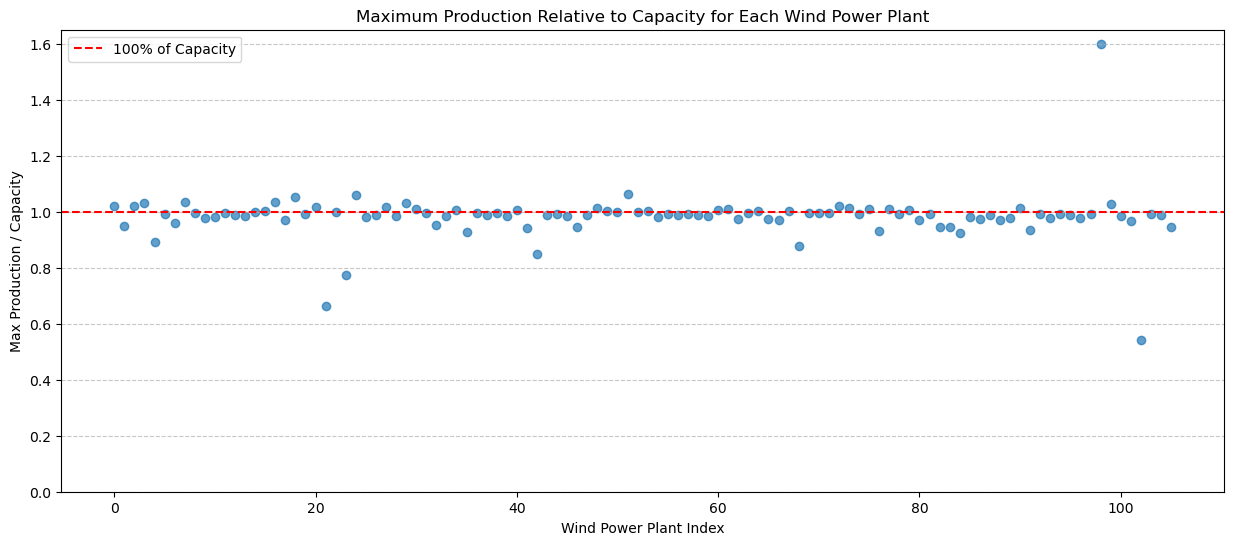

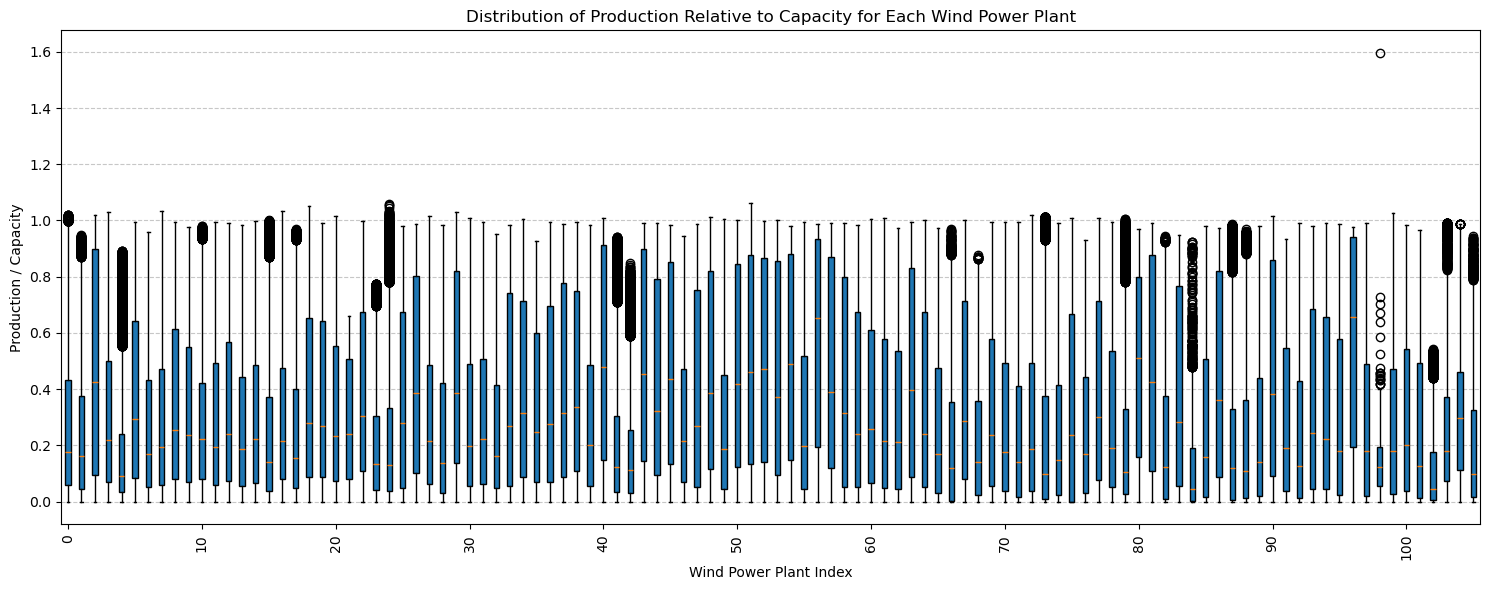

In [2]:
import matplotlib.pyplot as plt

# Prepare data for the boxplot (one boxplot per WPP)
production_ratios_per_wpp = [[entry[1] / capacity for entry in production_data] for production_data, capacity in zip(all_production_data, all_capacities)]
max_production_ratio_per_wpp = [max(ratios) for ratios in production_ratios_per_wpp]

# Plotting
plt.figure(figsize=(15, 6))
plt.scatter(range(len(max_production_ratio_per_wpp)), max_production_ratio_per_wpp, alpha=0.7)
plt.axhline(y=1.0, color='red', linestyle='--', label='100% of Capacity')
plt.xlabel('Wind Power Plant Index')
plt.ylabel('Max Production / Capacity')
plt.title('Maximum Production Relative to Capacity for Each Wind Power Plant')
plt.ylim(0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot boxplot with thin boxes
plt.figure(figsize=(15, 6))
plt.boxplot(production_ratios_per_wpp, widths=0.4, vert=True, patch_artist=True, showfliers=True)
plt.xlabel('Wind Power Plant Index')
plt.ylabel('Production / Capacity')
plt.title('Distribution of Production Relative to Capacity for Each Wind Power Plant')
step = 10  # Interval for the ticks
num_wpps = len(all_production_data)
tick_positions = np.arange(0, num_wpps, step) + 1  # 1-indexed positions for boxplot
tick_labels = np.arange(0, num_wpps, step)  # Actual WPP indices (0, 10, 20, ...)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


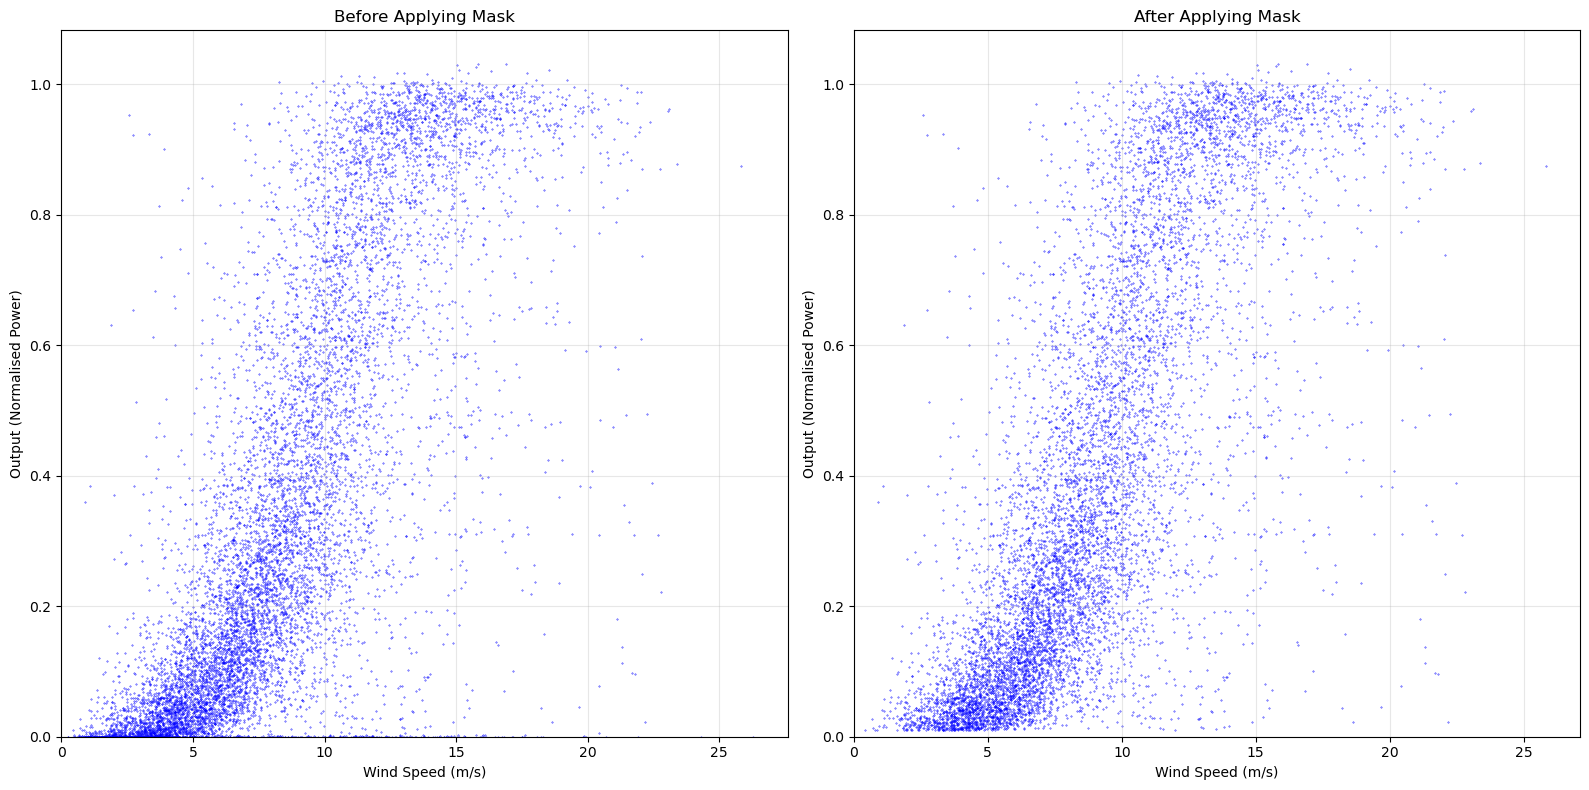

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Erstelle eine Maske mit 10.000 zufälligen Indizes
random_indices = np.random.choice(combined_features_raw.shape[0], 10000, replace=False)

combined_features_subset = combined_features_raw.copy()
output_subset = output_raw.copy()

# Extrahiere die entsprechenden Werte aus den Arrays
combined_features_subset = combined_features_subset[random_indices]
output_subset = output_subset[random_indices]

# mask = ~((output_subset.flatten() < 0.01) & (combined_features_subset[:, -1] > 7.0))
mask = output_subset.flatten() > 0.01

# Apply the mask to filter the subsets
combined_features_filtered = combined_features_subset[mask]
output_filtered = output_subset[mask]

# Generate a 2x1 plot to compare before and after applying the mask

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot before applying the mask
axes[0].scatter(combined_features_subset[:, -1], output_subset, s=0.1, color='blue')
axes[0].set_title("Before Applying Mask")
axes[0].set_xlabel("Wind Speed (m/s)")
axes[0].set_ylabel("Output (Normalised Power)")
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].grid(alpha=0.3)

# Plot after applying the mask
axes[1].scatter(combined_features_filtered[:, -1], output_filtered, s=0.1, color='blue')
axes[1].set_title("After Applying Mask")
axes[1].set_xlabel("Wind Speed (m/s)")
axes[1].set_ylabel("Output (Normalised Power)")
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

<h1>Scale feature vector and define Dataset

In [3]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch
import joblib

# combined_features = combined_features_subset.copy()
# output = output_subset.copy()
combined_features = combined_features_filtered.copy()
output = output_filtered.copy()

# Separate Scaler für jedes Feature
scaler_wind = StandardScaler()
scaler_ages = StandardScaler()
scaler_hub_heights = StandardScaler()

# Skalieren der einzelnen Features
combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
combined_features[:, -3] = scaler_hub_heights.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale hub heights

# Speichere alle Scaler in einem Dictionary
scalers = {
    "winds": scaler_wind,
    "ages": scaler_ages,
    "hub_heights": scaler_hub_heights,
}

# Speichere das Dictionary mit Joblib
joblib.dump(scalers, "model2/scalers.pkl")

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
dataset = WindPowerDataset(combined_features, output)

<h1>Define Model

In [10]:
import torch.nn as nn

# class MLP(nn.Module):
#     def __init__(self, input_size):
#         super(MLP, self).__init__()
#         # define layers as nn.Sequential, for better visualisability in TensorBoard and compatibility with DeepExplainer from SHAP
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         return self.model(x)

# class MLP(nn.Module):
#     def __init__(self, input_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.fc4(x)  # No activation in the output layer for regression
#         return x

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.33659592356347234)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation in the output layer for regression
        return x

In [11]:
import torch
from torch.utils.tensorboard import SummaryWriter

# Create a dummy input with the same shape as your model's input
input_size = torch.load("model2/input_size", weights_only=True)
dummy_input = torch.rand(1, input_size)  # Batch size of 1, with "input_size" features

# Instantiate your model
model = MLP(input_size=input_size)

# Initialize the TensorBoard writer
writer = SummaryWriter("runs/mlp_model")

# Add the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the writer
writer.close()

In [4]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, use_dropout=False, dropout_rate=0.3, 
                 use_batch_norm=False, activation_fn=nn.ReLU):
        super(MLP, self).__init__()

        layers = []

        # Erste Schicht
        layers.append(nn.Linear(input_size, 256))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(256))
        layers.append(activation_fn())

        # Zweite Schicht
        layers.append(nn.Linear(256, 128))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(128))
        layers.append(activation_fn())

        # Dritte Schicht
        layers.append(nn.Linear(128, 64))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(64))
        layers.append(activation_fn())

        # Dropout nach der letzten versteckten Schicht (optional)
        if use_dropout:
            layers.append(nn.Dropout(dropout_rate))

        # Ausgabeschicht
        layers.append(nn.Linear(64, 1))

        # Modell zusammenstellen
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

<h1>Old code for hyperparameter search, validation and deployment in one</h1>
The computing resources on the personal PC are

• 4 physical CPU cores, with Hyper-Threading 4 additional virtual CPU cores --> 8 logical CPU cores

• 1 integrated GPU, that can be used with import torch_directml, device = torch_directml.device(), but it is much slower than the CPUs (and doesn't support HuberLoss: this calculation must be outsourced to the CPU. And no float64, only float32 datatypes)

In [5]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Hyperparameter space
param_space = {
    "hidden_size": [32],
    "batch_size": [32],
    "lr": [1e-3],
    "number_epochs": [10],
}

# Select random parameter set
def random_search(param_space, n_trials):
    trials = []
    for _ in range(n_trials):
        trial = {key: random.choice(values) for key, values in param_space.items()}
        trials.append(trial)
    return trials

n_trials = 1
params = random_search(param_space, n_trials)[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

# Model
input_size = combined_features.shape[1]
model = MLP(input_size=input_size).to(device)

# Loss function and optimizer
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# Training
for epoch in range(params["number_epochs"]):
    print(f"Epoch {epoch + 1}/{params['number_epochs']}")
    model.train()
    training_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)

        training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Training Loss: {training_loss / len(train_loader):.4f}")

# Validation
model.eval()
val_loss = 0.0
mae_loss = 0.0
mse_loss = 0.0

# For later visualization
batch_x_all = []
batch_y_all = []
val_outputs_all = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x_all.append(batch_x.detach().cpu().numpy())
        batch_y_all.append(batch_y.detach().cpu().numpy())

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        val_outputs = model(batch_x)

        val_outputs_all.append(val_outputs.detach().cpu().numpy())

        val_loss += criterion(val_outputs, batch_y).item()  # Huber loss
        mae_loss += nn.L1Loss()(val_outputs, batch_y).item()  # MAE
        mse_loss += nn.MSELoss()(val_outputs, batch_y).item()  # MSE

batch_x_all = np.concatenate(batch_x_all)
batch_y_all = np.concatenate(batch_y_all)
val_outputs_all = np.concatenate(val_outputs_all)

val_loss /= len(val_loader)
mae_loss /= len(val_loader)
mse_loss /= len(val_loader)
rmse_loss = np.sqrt(mse_loss)  # RMSE

print(f"Validation Loss (Huber): {val_loss:.4f}")
print(f"Validation Loss (MAE): {mae_loss:.4f}")
print(f"Validation Loss (MSE): {mse_loss:.4f}")
print(f"Validation Loss (RMSE): {rmse_loss:.4f}")

# Save model
torch.save(model.state_dict(), "model2/trained_parameters.pth")
print(f"Model parameters saved")

torch.save(input_size, "model2/input_size")
print(f"Input size saved")


Epoch 1/10
Training Loss: 0.0234
Epoch 2/10
Training Loss: 0.0166
Epoch 3/10
Training Loss: 0.0159
Epoch 4/10
Training Loss: 0.0155
Epoch 5/10
Training Loss: 0.0151
Epoch 6/10
Training Loss: 0.0150
Epoch 7/10
Training Loss: 0.0151
Epoch 8/10
Training Loss: 0.0149
Epoch 9/10
Training Loss: 0.0149
Epoch 10/10
Training Loss: 0.0148
Validation Loss (Huber): 0.0159
Validation Loss (MAE): 0.1261
Validation Loss (MSE): 0.0319
Validation Loss (RMSE): 0.1786
Model parameters saved
Input size saved


<h1>Visualisation of validation results

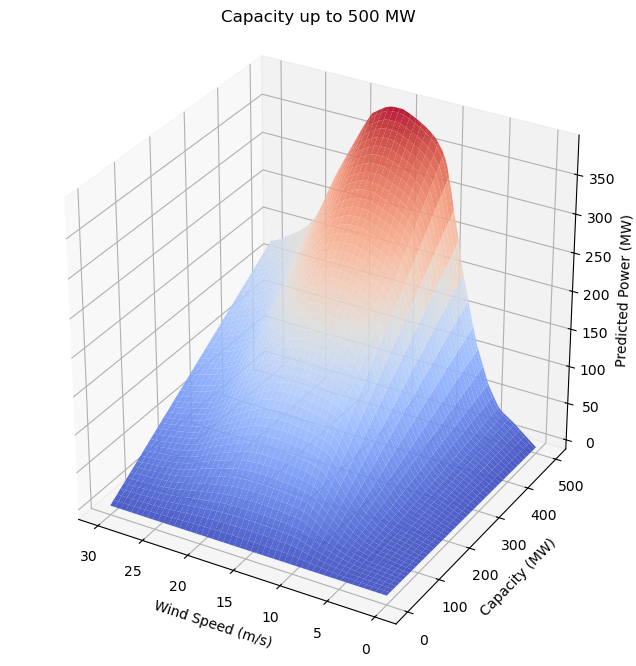

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib

# Laden von Modell und Scaler
input_size = torch.load("model2/input_size", weights_only=True)
model = MLP(input_size=input_size)
model.load_state_dict(torch.load("model2/trained_parameters.pth", weights_only=True))
model.eval()

scalers = joblib.load("model2/scalers.pkl")

def generate_plot(capacities, hub_height=100, age=114):
    wind_speeds = np.linspace(0, 30, 500)  # Windgeschwindigkeiten von 0 bis 30 m/s

    # Meshgrid erstellen
    wind_speeds_grid, capacities_grid = np.meshgrid(wind_speeds, capacities)
    wind_speeds_flat = wind_speeds_grid.flatten()
    capacities_flat = capacities_grid.flatten()

    # Features skalieren
    scaled_wind_speeds = scalers["winds"].transform(wind_speeds_flat.reshape(-1, 1)).flatten()
    avg_turbine_type = np.ones((len(scaled_wind_speeds), input_size - 3)) / (input_size - 3)  # Durchschnittliche Turbine
    fixed_hub_height = scalers["hub_heights"].transform(np.full((len(scaled_wind_speeds), 1), hub_height)).flatten()
    fixed_age = scalers["ages"].transform(np.full((len(scaled_wind_speeds), 1), age)).flatten()

    # Alle Features kombinieren
    all_features = np.hstack([
        avg_turbine_type,
        fixed_hub_height.reshape(-1, 1),
        fixed_age.reshape(-1, 1),
        scaled_wind_speeds.reshape(-1, 1)
    ])

    # Vorhersagen machen
    input_tensor = torch.tensor(all_features, dtype=torch.float32)
    with torch.no_grad():
        predictions = (model(input_tensor).numpy() * capacities_flat.reshape(-1, 1)).flatten()

    # Vorhersagen an Grid anpassen
    predictions_grid = predictions.reshape(wind_speeds_grid.shape)

    # 3D-Plot erstellen
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(wind_speeds_grid, capacities_grid, predictions_grid, cmap='coolwarm', edgecolor='none', alpha=0.9)

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_ylabel("Capacity (MW)")
    ax.set_zlabel("Predicted Power (MW)")
    ax.set_title("Capacity up to 500 MW")
    ax.set_box_aspect([1, 1, 1])

    plt.show()

# Generate the plot
generate_plot(np.linspace(0, 500, 100))


<h1>Generalisation

In [ ]:
hub_height_min_MLP = min(all_hub_heights)
hub_height_max_MLP = max(all_hub_heights)
age_min_MLP = min(ages)
age_max_MLP = max(ages)
print(f"MLP: Hub height min = {hub_height_min_MLP}, Hub height max = {hub_height_max_MLP}, Age min = {age_min_MLP}, Age max = {age_max_MLP}")

df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
hub_height_min_twp = min(df["Hub height"].values)
hub_height_max_twp = max(df["Hub height"].values)
age_min_twp = min(df["Ages months"].values)
age_max_twp = max(df["Ages months"].values)
print(f"The Wind Power: Hub height min = {hub_height_min_twp}, Hub height max = {hub_height_max_twp}, Age min = {age_min_twp}, Age max = {age_max_twp}")

<h3>1. Hub heights

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib

# Load model and scaler
input_size = torch.load("model2/input_size", weights_only=True)
model = MLP(input_size=input_size)
model.load_state_dict(torch.load("model2/trained_parameters.pth", weights_only=True))
model.eval()

scalers = joblib.load("model2/scalers.pkl")
known_turbine_types = np.load("model2/turbine_types_order.npy")

df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
hub_height_min = min(df["Hub height"].values)
hub_height_max = max(df["Hub height"].values)
age_min = min(df["Ages months"].values)
age_max = max(df["Ages months"].values)

def generate_plot(feature_range, feature_name, ax, wind_speed_range=(0, 30), hub_height=90, age=100):
    wind_speeds = np.linspace(*wind_speed_range, 500)  # Wind speeds from 0 to 30 m/s

    # Create meshgrid for wind speeds and the feature range (hub height or age)
    wind_speeds_grid, feature_grid = np.meshgrid(wind_speeds, feature_range)
    wind_speeds_flat = wind_speeds_grid.flatten()
    feature_flat = feature_grid.flatten()

    # Scale features
    wind_speeds = scalers["winds"].transform(wind_speeds_flat.reshape(-1, 1)).flatten()
    avg_turbine_type = np.zeros((len(wind_speeds), len(known_turbine_types))) / len(known_turbine_types)

    if feature_name == "hub_height":
        hub_heights = scalers["hub_heights"].transform(feature_flat.reshape(-1, 1)).flatten()
        ages = scalers["ages"].transform(np.full((len(wind_speeds), 1), age)).flatten()
    elif feature_name == "age":
        hub_heights = scalers["hub_heights"].transform(np.full((len(wind_speeds), 1), hub_height)).flatten()
        ages = scalers["ages"].transform(feature_flat.reshape(-1, 1)).flatten()

    # Construct feature matrix
    all_features = np.hstack([
        avg_turbine_type,
        hub_heights.reshape(-1, 1),
        ages.reshape(-1, 1),
        wind_speeds.reshape(-1, 1)
    ])

    # Make predictions
    input_tensor = torch.tensor(all_features, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(input_tensor).numpy().flatten()

    # Reshape predictions to match the grid
    predictions_grid = predictions.reshape(wind_speeds_grid.shape)

    # Plot the surface
    surf = ax.plot_surface(wind_speeds_grid, feature_grid, predictions_grid, cmap='coolwarm', edgecolor='none', alpha=0.9)

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_ylabel("Hub Height (m)" if feature_name == "hub_height" else "Age (months)")
    ax.set_zlabel("Predicted Power (normalised)")
    ax.set_box_aspect([1, 1, 1])
    


# **1. Image: Trained value range**
fig1, axes1 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig1.text(0.07, 0.5, "Hub Height from 47 to 130 m", va='center', ha='center', rotation='vertical', fontsize=14, fontweight='bold')

generate_plot(np.linspace(47, 130, 100), feature_name="hub_height", ax=axes1[0], age=7)
axes1[0].set_title("Age = 7 months")

generate_plot(np.linspace(47, 130, 100), feature_name="hub_height", ax=axes1[1], age=71.25)
axes1[1].set_title("Age = 71.25 months")

generate_plot(np.linspace(47, 130, 100), feature_name="hub_height", ax=axes1[2], age=135.5)
axes1[2].set_title("Age = 135.5 months")

generate_plot(np.linspace(47, 130, 100), feature_name="hub_height", ax=axes1[3], age=199.75)
axes1[3].set_title("Age = 199.75 months")

generate_plot(np.linspace(47, 130, 100), feature_name="hub_height", ax=axes1[4], age=264)
axes1[4].set_title("Age = 264 months")

plt.show()


# **2. Image: New value range for hub heights**
fig2, axes2 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig2.text(0.07, 0.5, "Hub Height from 14 to 205 m", va='center', ha='center', rotation='vertical', fontsize=14, fontweight='bold')

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[0], age=7)
axes2[0].set_title("Age = 7 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[1], age=71.25)
axes2[1].set_title("Age = 71.25 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[2], age=135.5)
axes2[2].set_title("Age = 135.5 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[3], age=199.75)
axes2[3].set_title("Age = 199.75 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[4], age=264)
axes2[4].set_title("Age = 264 months")

plt.show()

# **3. Image: New value range for hub heights and ages**
fig3, axes3 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig3.text(0.07, 0.5, "Hub Height from 14 to 205 m", va='center', ha='center', rotation='vertical', fontsize=14, fontweight='bold')

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[0], age=4)
axes3[0].set_title("Age = 4 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[1], age=142.5)
axes3[1].set_title("Age = 142.5 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[2], age=281)
axes3[2].set_title("Age = 281 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[3], age=419.5)
axes3[3].set_title("Age = 419.5 months")

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[4], age=558)
axes3[4].set_title("Age = 558 months")

plt.show()

NameError: name 'MLP' is not defined

<h3>2. Ages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib

# Load model and scaler
input_size = torch.load("model2/input_size", weights_only=True)
model = MLP(input_size=input_size)
model.load_state_dict(torch.load("model2/trained_parameters.pth", weights_only=True))
model.eval()

scalers = joblib.load("model2/scalers.pkl")
known_turbine_types = np.load("model2/turbine_types_order.npy")

df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
hub_height_min = min(df["Hub height"].values)
hub_height_max = max(df["Hub height"].values)
age_min = min(df["Ages months"].values)
age_max = max(df["Ages months"].values)

def generate_plot(feature_range, feature_name, ax, wind_speed_range=(0, 30), hub_height=90, age=100):
    wind_speeds = np.linspace(*wind_speed_range, 500)  # Wind speeds from 0 to 30 m/s

    # Create meshgrid for wind speeds and the feature range (hub height or age)
    wind_speeds_grid, feature_grid = np.meshgrid(wind_speeds, feature_range)
    wind_speeds_flat = wind_speeds_grid.flatten()
    feature_flat = feature_grid.flatten()

    # Scale features
    wind_speeds = scalers["winds"].transform(wind_speeds_flat.reshape(-1, 1)).flatten()
    avg_turbine_type = np.zeros((len(wind_speeds), len(known_turbine_types))) / len(known_turbine_types)

    if feature_name == "hub_height":
        hub_heights = scalers["hub_heights"].transform(feature_flat.reshape(-1, 1)).flatten()
        ages = scalers["ages"].transform(np.full((len(wind_speeds), 1), age)).flatten()
    elif feature_name == "age":
        hub_heights = scalers["hub_heights"].transform(np.full((len(wind_speeds), 1), hub_height)).flatten()
        ages = scalers["ages"].transform(feature_flat.reshape(-1, 1)).flatten()

    # Construct feature matrix
    all_features = np.hstack([
        avg_turbine_type,
        hub_heights.reshape(-1, 1),
        ages.reshape(-1, 1),
        wind_speeds.reshape(-1, 1)
    ])

    # Make predictions
    input_tensor = torch.tensor(all_features, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(input_tensor).numpy().flatten()

    # Reshape predictions to match the grid
    predictions_grid = predictions.reshape(wind_speeds_grid.shape)

    # Plot the surface
    surf = ax.plot_surface(wind_speeds_grid, feature_grid, predictions_grid, cmap='coolwarm', edgecolor='none', alpha=0.9)

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_ylabel("Hub Height (m)" if feature_name == "hub_height" else "Age (months)")
    ax.set_zlabel("Predicted Power (normalised)")
    ax.set_box_aspect([1, 1, 1])
    

# **1. Image: Trained value range**
fig1, axes1 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig1.text(0.07, 0.5, "Age from 7 to 264 months", va='center', ha='center', rotation='vertical', fontsize=14, fontweight='bold')

generate_plot(np.linspace(7, 264, 100), feature_name="age", ax=axes1[0], hub_height=47)
axes1[0].set_title("Hub Height = 47 m")

generate_plot(np.linspace(7, 264, 100), feature_name="age", ax=axes1[1], hub_height=67.75)
axes1[1].set_title("Hub Height = 67.75 m")

generate_plot(np.linspace(7, 264, 100), feature_name="age", ax=axes1[2], hub_height=88.5)
axes1[2].set_title("Hub Height = 88.5 m")

generate_plot(np.linspace(7, 264, 100), feature_name="age", ax=axes1[3], hub_height=122.75)
axes1[3].set_title("Hub Height = 122.75 m")

generate_plot(np.linspace(7, 264, 100), feature_name="age", ax=axes1[4], hub_height=130)
axes1[4].set_title("Hub Height = 130 m")

plt.show()

# **2. Image: New value range for ages**
fig2, axes2 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig2.text(0.07, 0.5, "Age from 4 to 558 months", va='center', ha='center', rotation='vertical', fontsize=14, fontweight='bold')

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes2[0], hub_height=47)
axes2[0].set_title("Hub Height = 47 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes2[1], hub_height=67.5)
axes2[1].set_title("Hub Height = 67.5 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes2[2], hub_height=88.5)
axes2[2].set_title("Hub Height = 88.5 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes2[3], hub_height=122.75)
axes2[3].set_title("Hub Height = 122.75 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes2[4], hub_height=130)
axes2[4].set_title("Hub Height = 130 m")

plt.show()


# **3. Image: New value range for ages and hub heights**
fig3, axes3 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig3.text(0.07, 0.5, "Age from 4 to 558 months", va='center', ha='center', rotation='vertical', fontsize=14, fontweight='bold')

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes3[0], hub_height=14)
axes3[0].set_title("Hub Height = 14 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes3[1], hub_height=61.75)
axes3[1].set_title("Hub Height = 61.75 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes3[2], hub_height=109.5)
axes3[2].set_title("Hub Height = 109.5 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes3[3], hub_height=133.25)
axes3[3].set_title("Hub Height = 133.25 m")

generate_plot(np.linspace(4, 558, 100), feature_name="age", ax=axes3[4], hub_height=205)
axes3[4].set_title("Hub Height = 205 m")

plt.show()


<h3>Boxplots Capacities

Mean capacity (Training WPPs): 179.89 MW
Mean capacity (Forecasting WPPs): 10.91 MW


C:\Users\alexa\AppData\Local\Temp\ipykernel_11056\1915950150.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=False, patch_artist=True, labels=["Forecasting WPPs", "Training WPPs"], positions=[1, 1.5], widths=0.3)


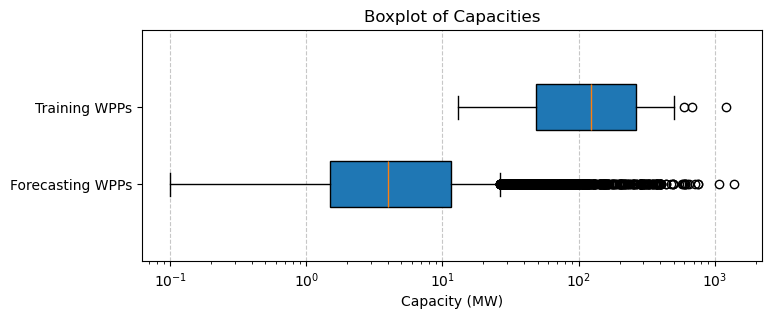

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read data
df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
capacities_the_wind_power = df['Total power'].values / 1e3  # Convert to MW

# Calculate means
mean_all_capacities = np.mean(all_capacities)
mean_capacities_the_wind_power = np.mean(capacities_the_wind_power)

# Print the mean values and scaling factor
print(f"Mean capacity (Training WPPs): {mean_all_capacities:.2f} MW")
print(f"Mean capacity (Forecasting WPPs): {mean_capacities_the_wind_power:.2f} MW")

# Plot boxplot
data = [capacities_the_wind_power, all_capacities]

plt.figure(figsize=(8, 3))
plt.boxplot(data, vert=False, patch_artist=True, labels=["Forecasting WPPs", "Training WPPs"], positions=[1, 1.5], widths=0.3)
plt.title("Boxplot of Capacities")
plt.xlabel("Capacity (MW)")
plt.xscale("log")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<h3>Other Plots

C:\Users\alexa\AppData\Local\Temp\ipykernel_11056\3590495365.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', 2*len(known_turbine_types))


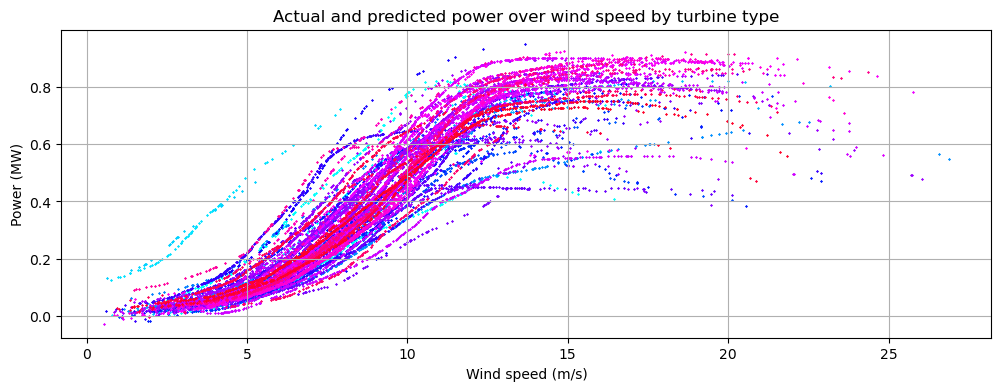

In [29]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_validation = scaler_wind.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

known_turbine_types = np.load("model2/turbine_types_order.npy")

# reconstruct original turbine types
turbine_types_validation = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_validation = encoder.categories_[0][turbine_types_validation]

colors = plt.cm.get_cmap('hsv', 2*len(known_turbine_types))

# Erstellen des Scatterplots mit verschiedenen Farben für Turbinentypen
plt.figure(figsize=(12, 4))

# Für jeden Turbinentyp einen Scatter-Plot mit einer anderen Farbe
for i, turbine_type in enumerate(known_turbine_types):
    mask = turbine_types_validation == turbine_type  # Maske für den jeweiligen Turbinentyp
    #plt.scatter(wind_speeds_validation[mask], batch_y_all[mask], s=0.5, color=colors(i), label=f"Turbine Type {turbine_type} - Actual")
    plt.scatter(wind_speeds_validation[mask], val_outputs_all[mask], s=0.5, color=colors(len(known_turbine_types)+i), marker='x', label=f"Turbine Type {turbine_type} - Predicted")

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed by turbine type')
#plt.legend()
plt.grid(True)
plt.show()

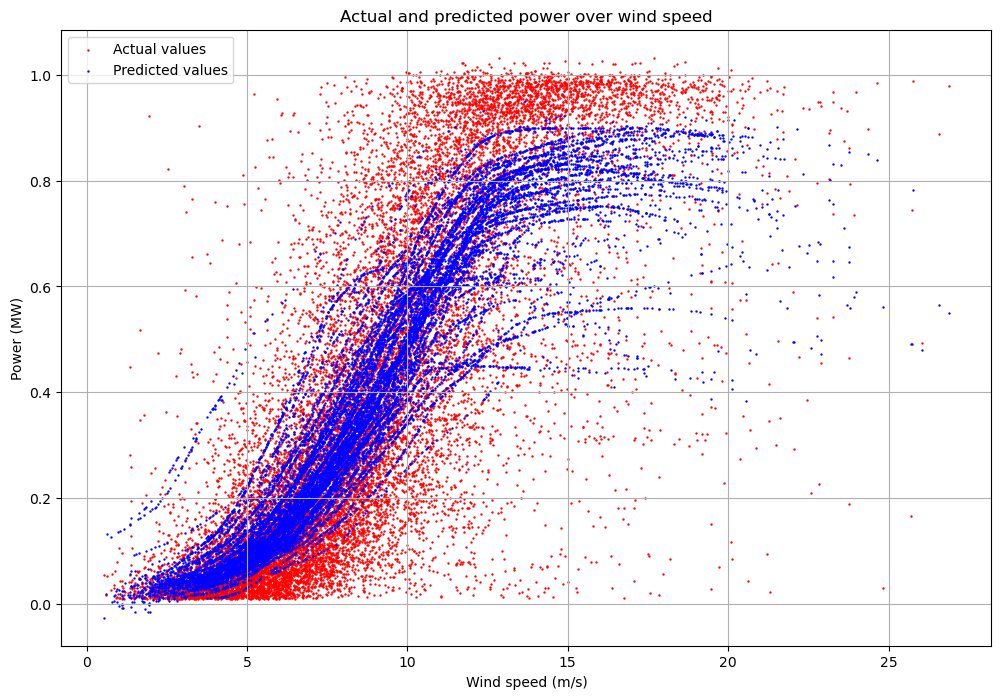

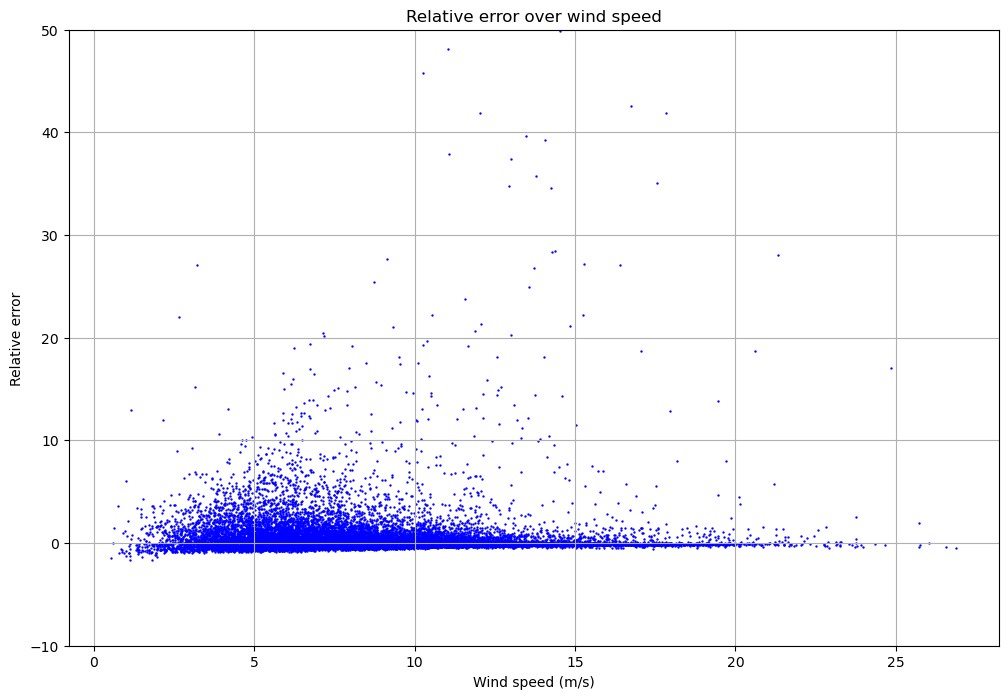

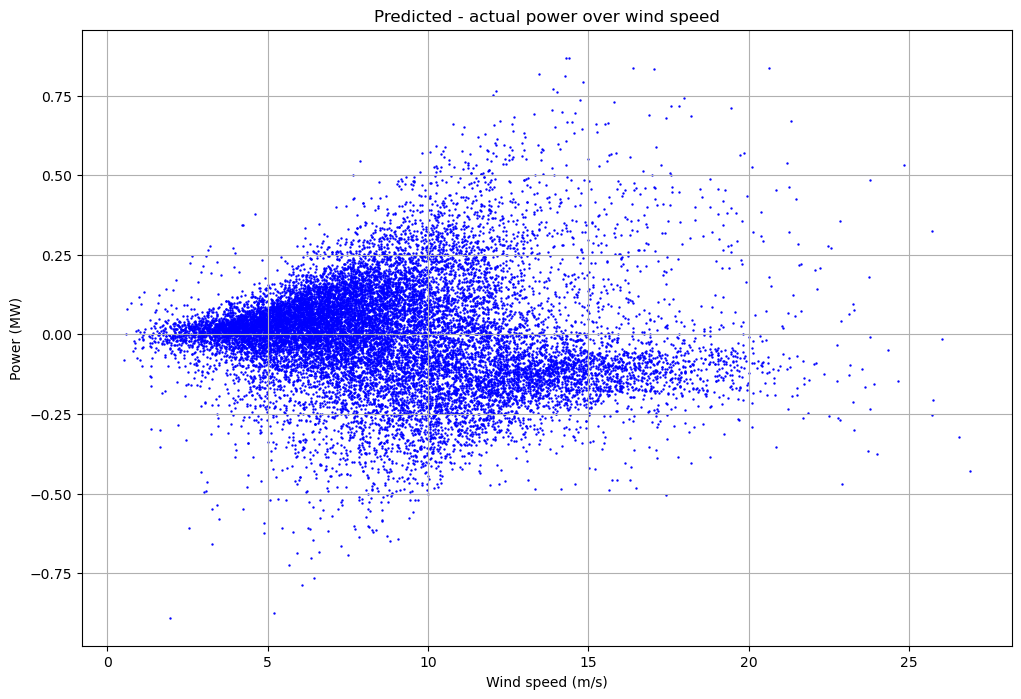

,wind speed,actual values,predicted values
0,4.440000,0.0567,0.077425
1,12.450000,0.8114,0.732911
2,12.740000,0.9251,0.718674
3,13.970000,0.9770,0.862454
4,15.400001,0.9625,0.872260
...,...,...,...
17649,5.910000,0.2498,0.107723
17650,10.470000,0.7798,0.650354
17651,6.430000,0.3609,0.173307
17652,4.000000,0.0389,0.051419


In [34]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_true = scaler_wind.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# capacities_true = scaler_capacities.inverse_transform(batch_x_all[:, -3].reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_true, batch_y_all, s=0.5, color='red', label="Actual values")
plt.scatter(wind_speeds_true, val_outputs_all, s=0.5, color='blue', label="Predicted values")
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_true, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)
plt.ylim(-10, 50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Relative error')
plt.title('Relative error over wind speed')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_true, val_outputs_all-batch_y_all, color='blue', s=0.5)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Predicted - actual power over wind speed')
plt.grid(True)
plt.show()

# Tabelle erstellen und anzeigen
results_df = pd.DataFrame({
    "wind speed": wind_speeds_true,
    "actual values": batch_y_all.flatten(),
    "predicted values": val_outputs_all.flatten()
})
display(results_df)

<h3>Histograms showing error distribution

In [46]:
import numpy as np

# Fehlerberechnung
absolute_errors = batch_y_all - val_outputs_all # actual - predicted
relative_errors = absolute_errors / batch_y_all

# Berechnung von Mittelwert und Standardabweichung
mean_abs_error = np.mean(absolute_errors)
std_abs_error = np.std(absolute_errors)

mean_rel_error = np.mean(relative_errors)
std_rel_error = np.std(relative_errors)

In [50]:
mean_abs_error, std_abs_error, mean_rel_error, std_rel_error

(0.00445945, 0.16852188, -0.6081582, 2.173968)

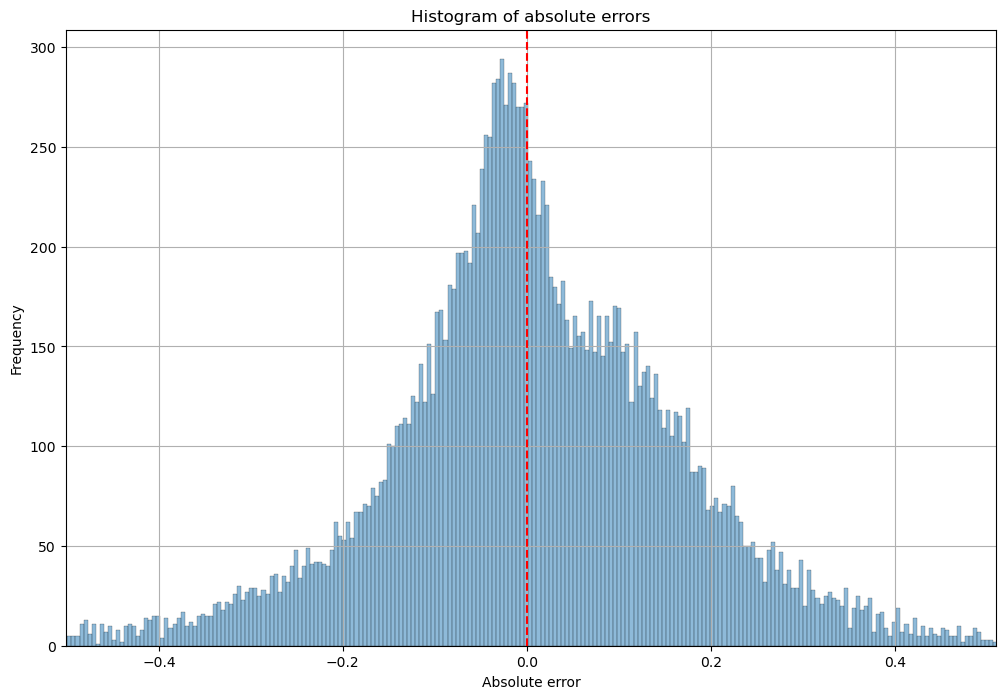

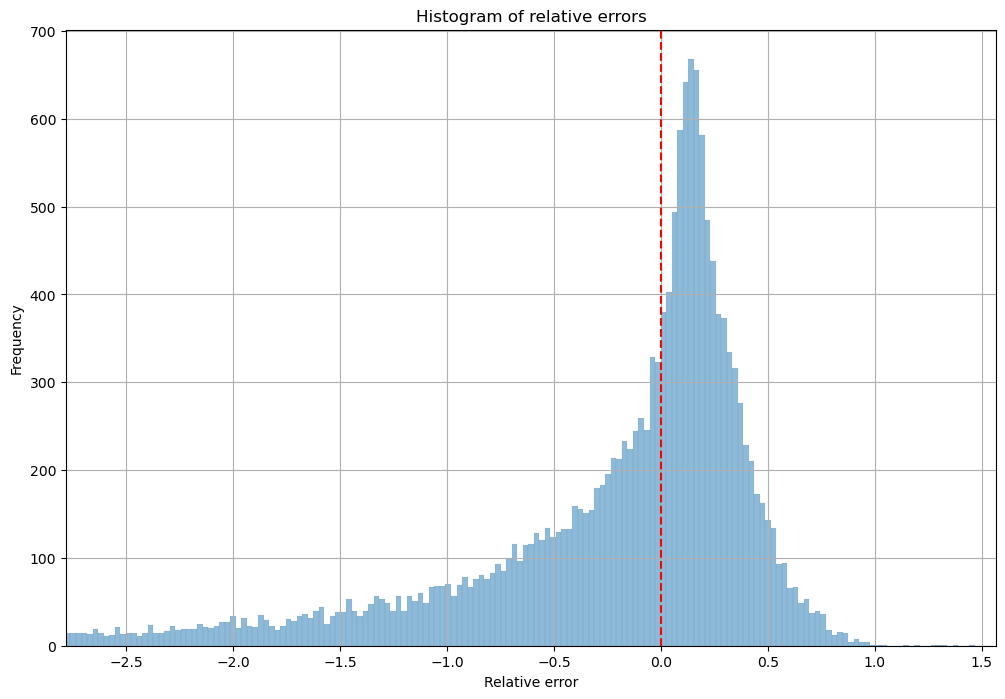

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.histplot(absolute_errors, bins=400, kde=False, legend=False)
plt.xlim(mean_abs_error - 3*std_abs_error, mean_abs_error + 3*std_abs_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Histogram of absolute errors")
plt.xlabel("Absolute error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(relative_errors, bins=2000, kde=False, legend=False)
plt.xlim(mean_rel_error - std_rel_error, mean_rel_error + std_rel_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Histogram of relative errors")
plt.xlabel("Relative error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

<h1>Feature Importance

In [22]:
import numpy as np

# Feature-Namen definieren
feature_names = np.array((
    list(encoder.get_feature_names_out(["Turbine"])) + 
    ["Hub_height", "Age", "Wind_speed"]
))

In [23]:
import numpy as np

# Maske mit zufälligen Indizes erstellen
random_indices = np.random.choice(len(combined_features), size=1000, replace=False)

# Werte aus combined_features basierend auf der Maske auswählen
masked_features = combined_features[random_indices]

model.eval()

MLP(
  (fc1): Linear(in_features=49, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
)

1. shapley-values

In [24]:
import torch
import shap

# Eingabe für den SHAP-Explainer vorbereiten
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = torch.tensor(masked_features, dtype=torch.float32).to(device)

# SHAP-Explainer erstellen
explainer = shap.GradientExplainer(model, input_tensor)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(input_tensor)

# SHAP-Werte umformen
shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

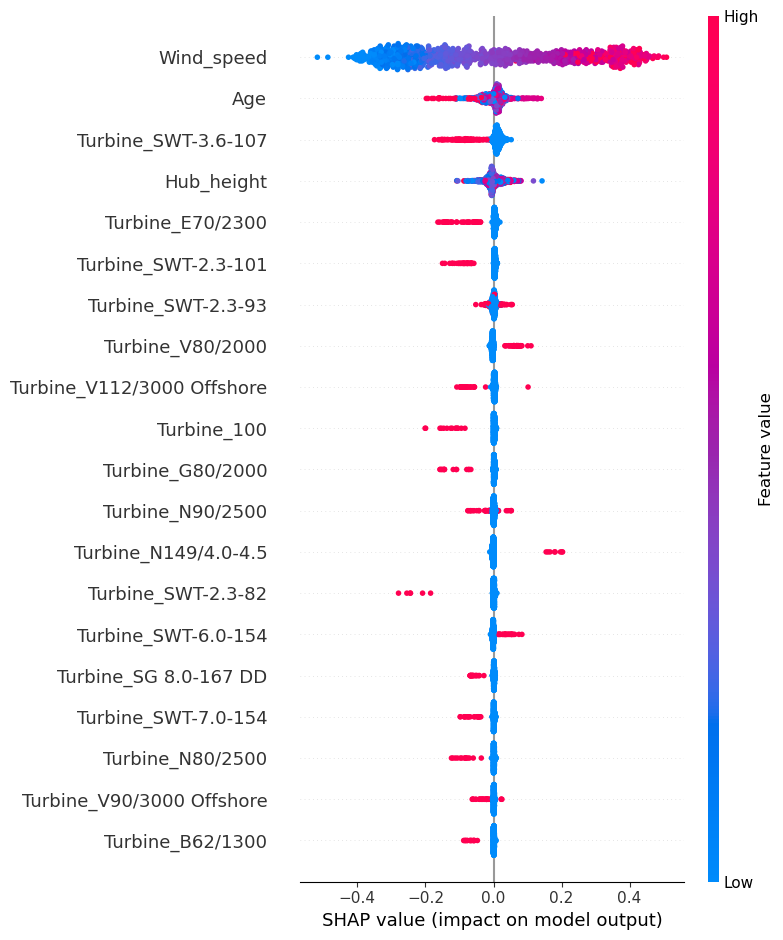

In [25]:
import shap

shap.summary_plot(shap_values_reshaped, masked_features, feature_names)

In [ ]:
import shap
import torch

shap.initjs()

# Modellvorhersagen auf dem Eingabedatensatz berechnen
base_value = model(torch.tensor(masked_features, dtype=torch.float32).to(device)).mean().item()

shap.plots.force(base_value, shap_values_reshaped, feature_names)

In [ ]:
import shap
import numpy as np

# Base Value in ein Array umwandeln
base_values_array = np.full((shap_values_reshaped.shape[0],), base_value)

# SHAP Explanation-Objekt erstellen
shap_values_explanation = shap.Explanation(
    values=shap_values_reshaped,
    base_values=base_values_array,  # Array statt float
    data=masked_features,  # Eingabedaten
    feature_names=feature_names  # Feature-Namen
)

# Bar-Plot erstellen
shap.plots.bar(shap_values_explanation)

2. gradient method

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Modell in Evaluierungsmodus
model.eval()

# Eingabegröße reduzieren
input_tensor = torch.tensor(masked_features, dtype=torch.float32, requires_grad=True).to(device)

# Vorhersage berechnen
outputs = model(input_tensor)

# Mittleren Output für den Gradienten berechnen
outputs.mean().backward()

# Gradienten extrahieren und sortieren
feature_importance = input_tensor.grad.abs().mean(dim=0).cpu().detach().numpy()

# Nach Wichtigkeit sortieren
sorted_idx = np.argsort(feature_importance)

# Visualisierung
plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Average Gradient Magnitude")
plt.title("Feature Importance using Gradients")
plt.show()

3. Spearman Correlation Coefficient Matrix

In [ ]:
import pandas as pd
import seaborn as sns

num_turbine_type_columns = turbine_types_onehot.shape[1]

# DataFrame ohne Turbinentypen erstellen
df = pd.DataFrame(
    combined_features[:, num_turbine_type_columns:], 
    columns=["Hub Height", "Commissioning Date", "Wind Speed"]
)

# Ausgabe hinzufügen
df['Power'] = output.flatten()

# Spearman-Korrelation berechnen
spearman_corr_matrix = df.corr(method='spearman')

# Farbcodierte Tabelle anzeigen
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation Heatmap")
plt.show()